## Train the game prediction models
* Aggregate game-level dataframe into season-level statistics
* Compute statistics on first X% of the season, and predict games in final (100-X)% (e.g. X=70)
* Compute "advanced stats" (efficiency, effective field goal percentage, assist ratio, OReb ratio,
turnover rate) corrected for strength-of-schedule
* Engineer orthogonal features with PCA
* Try a variety of logistic regression and BDT models to predict probabilistic outcome
* Linear regressions to predict pace, total score, score margin

In [1]:
import os
import glob
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import watchcbb.utils as utils
import watchcbb.efficiency as eff
import watchcbb.sql as sql

### Load game-level dataframe

In [2]:
df = sql.df_from_query(""" SELECT * FROM game_data """)
df.head(10)

,Season,Date,gid,Type,WTeamID,WScore,LTeamID,LScore,Wrank,Lrank,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
0,2011,2010-11-08,2010-11-08_california-irvine_illinois,RG,illinois,79,california-irvine,65,13,-1,...,14,22,11,26,12,14,7,1,21,74.90
1,2011,2010-11-08,2010-11-08_pittsburgh_rhode-island,RG,pittsburgh,83,rhode-island,75,5,-1,...,13,16,9,20,16,16,7,6,25,75.62
2,2011,2010-11-08,2010-11-08_maryland_seattle,RG,maryland,105,seattle,76,-1,-1,...,17,22,13,16,11,27,18,1,31,98.36
3,2011,2010-11-08,2010-11-08_navy_texas,RG,texas,83,navy,52,-1,-1,...,10,18,5,21,8,16,5,5,24,80.44
4,2011,2010-11-10,2010-11-10_college-of-charleston_maryland,RG,maryland,75,college-of-charleston,74,-1,-1,...,16,19,10,25,12,22,8,8,19,77.64
5,2011,2010-11-10,2010-11-10_illinois-chicago_pittsburgh,RG,pittsburgh,97,illinois-chicago,54,5,-1,...,7,9,5,15,9,11,0,3,18,67.88
6,2011,2010-11-10,2010-11-10_illinois_toledo,RG,illinois,84,toledo,45,13,-1,...,10,19,3,16,9,23,6,0,14,72.00
7,2011,2010-11-10,2010-11-10_louisiana-tech_texas,RG,texas,89,louisiana-tech,58,-1,-1,...,13,20,13,25,4,22,6,5,21,83.74
8,2011,2010-11-12,2010-11-12_maryland-eastern-shore_tulane,RG,tulane,91,maryland-eastern-shore,62,-1,-1,...,19,26,9,16,11,21,4,2,28,78.04
9,2011,2010-11-12,2010-11-12_marquette_prairie-view,RG,marquette,97,prairie-view,58,-1,-1,...,7,11,3,13,12,20,11,3,27,79.12


### Partition each season into two parts: one to compute statistics, and one containg games to predict

In [3]:
FRAC = 0.7
first, second = utils.partition_games(df, frac=FRAC)
print(df.iloc[first].shape[0], df.iloc[second].shape[0])

38328 16432


### Compute aggregated stats as well as some composite advanced metrics

In [4]:
season_stats_dict = utils.compute_season_stats(df.iloc[first])
season_stats_df = utils.stats_dict_to_df(season_stats_dict)
utils.add_advanced_stats(season_stats_df)
season_stats_dict = utils.stats_df_to_dict(season_stats_df)
print(season_stats_df.shape)
season_stats_df.head()

(3497, 54)


,year,team_id,wins,losses,totOT,TScore,TFGM,TFGA,TFGM3,TFGA3,...,Torbp,Tftr,Oposs,Oeff,Oastr,Otovr,Oefgp,Oorbp,Oftr,rawpace
0,2011,air-force,12,8,2,1328,463,941,133,333,...,0.196078,0.414453,1261.96,101.825731,0.157057,0.169381,0.485780,0.338073,0.283486,61.890370
1,2011,akron,12,10,2,1498,527,1263,175,508,...,0.262003,0.306413,1522.28,96.434296,0.137450,0.190418,0.480897,0.315789,0.383721,68.349663
2,2011,alabama,15,7,1,1493,566,1249,96,311,...,0.356601,0.293034,1502.48,83.595123,0.110456,0.199252,0.409393,0.300525,0.346633,67.763164
3,2011,alabama-am,6,10,0,959,348,896,62,237,...,0.282004,0.377232,1143.32,90.875695,0.136156,0.209393,0.472254,0.323194,0.399773,71.501250
4,2011,alabama-birmingham,16,6,5,1537,547,1224,166,480,...,0.312789,0.307190,1472.84,94.375492,0.130914,0.164221,0.457404,0.308123,0.287420,64.801768


### Now correct everything for strength of schedule
The Top 25 "efficiency ratings" for a certain year are printed below

In [5]:
eff.compute_efficiency_ratings(season_stats_dict)
season_stats_df = utils.stats_dict_to_df(season_stats_dict)

In [6]:
season_stats_df[["year","team_id","Tneteff","Tcorroeff","Tcorrdeff","rawpace","pace"]]\
    .query('year==2018')\
    .sort_values('Tneteff', ascending=False).reset_index(drop=True).head(25)

,year,team_id,Tneteff,Tcorroeff,Tcorrdeff,rawpace,pace
0,2018,villanova,37.708238,129.875343,92.167105,71.399091,70.656272
1,2018,purdue,34.761396,123.531024,88.769629,70.041791,70.450607
2,2018,virginia,33.933450,114.334745,80.401295,62.175652,61.679676
3,2018,duke,33.138671,126.925882,93.787211,73.603459,74.111043
4,2018,michigan-state,32.975689,121.256876,88.281187,70.227264,69.250966
5,2018,kansas,29.033777,121.047028,92.013251,72.153913,71.695040
6,2018,cincinnati,27.969756,111.642218,83.672462,68.833636,68.380753
7,2018,texas-tech,26.201339,112.612491,86.411153,69.811613,68.836900
8,2018,tennessee,26.155361,115.796095,89.640734,68.925843,68.869876
9,2018,xavier,24.349552,120.255937,95.906384,72.955855,72.415991


### Put everything into a tidy dataframe for training models
* Randomly pick which team to use as "reference" team for relative statistics, so classes are balanced
* Add in a bunch of features that we may need for model fitting

In [7]:
data = utils.compile_training_data(df.iloc[second], season_stats_dict, random_seed=1)
print(data.shape)
data.query("tid1=='purdue' | tid2=='purdue'").sample(frac=1, random_state=1).head(10)

(16432, 30)


,season,date,gid,tid1,tid2,result,rank1,rank2,totscore,margin,...,Oefgp,Tftr,Otovr,Ttovr,Tastr,Oftr,Teff,Oeff,Oorbp,Tefgp
10692,2017,2017-02-25,2017-02-25_michigan_purdue,purdue,michigan,0,14,-1,152,-12,...,-0.060768,0.020341,-0.026247,0.031144,0.035118,-0.056239,0.180004,-9.570001,-0.048833,0.019865
5532,2014,2014-02-23,2014-02-23_nebraska_purdue,nebraska,purdue,1,-1,-1,133,19,...,0.027760,0.098607,0.007570,0.007118,-0.018887,0.054069,2.232555,0.876905,-0.043847,0.032322
9669,2016,2016-03-12,2016-03-12_michigan_purdue,michigan,purdue,0,-1,13,135,-17,...,0.072597,-0.055036,0.030464,-0.024086,-0.007041,-0.022954,5.833090,10.919921,0.052396,0.050062
12278,2018,2018-02-22,2018-02-22_illinois_purdue,illinois,purdue,0,-1,9,179,-7,...,0.061917,-0.017119,0.049764,0.031328,-0.052944,0.215312,-15.700852,7.757496,0.008183,-0.089762
6167,2014,2014-03-09,2014-03-09_northwestern_purdue,northwestern,purdue,1,-1,-1,139,9,...,-0.026544,0.007175,-0.018680,0.012880,0.002910,-0.002722,-8.603620,-4.616429,-0.035408,-0.006669
9200,2016,2016-03-01,2016-03-01_nebraska_purdue,purdue,nebraska,1,15,-1,143,19,...,-0.062136,0.008887,-0.031973,0.004721,0.052902,-0.128661,4.409718,-12.478582,-0.062345,0.020769
9028,2016,2016-02-27,2016-02-27_maryland_purdue,maryland,purdue,0,10,20,162,-4,...,0.018855,0.016840,0.002991,0.015143,-0.022269,-0.006775,3.182439,5.093174,0.060311,0.042583
13586,2019,2019-02-19,2019-02-19_indiana_purdue,indiana,purdue,0,-1,15,94,-2,...,-0.023140,0.054414,-0.024639,0.027091,-0.014661,-0.044120,-14.423469,-3.561095,0.011251,-0.026265
4752,2013,2013-03-20,2013-03-20_purdue_western-illinois,purdue,western-illinois,1,-1,-1,148,14,...,-0.024026,-0.046855,-0.003987,-0.016247,0.008413,0.006509,1.673499,-0.198411,-0.023393,-0.008216
9651,2016,2016-03-11,2016-03-11_illinois_purdue,purdue,illinois,1,13,-1,147,31,...,-0.098700,-0.007943,-0.031286,0.024641,0.034799,0.015111,6.964614,-15.241924,-0.076417,0.026316


### Plot histograms of various features for winning/losing teams

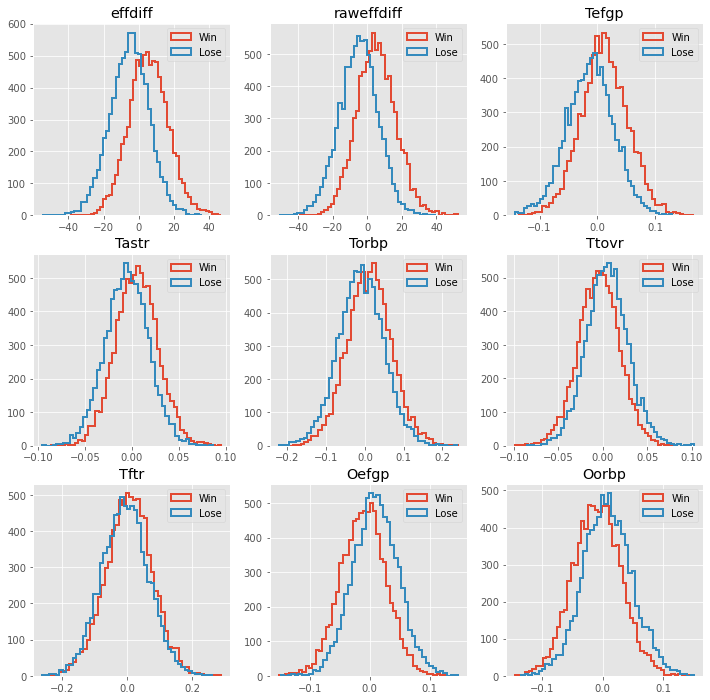

In [8]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
axs = axs.flatten()
toplot = ['effdiff','raweffdiff','Tefgp',
          'Tastr','Torbp', 'Ttovr', 
          'Tftr','Oefgp','Oorbp'
         ]
for name,ax in zip(toplot,axs):
    ax.hist(data.loc[ data.result.astype(bool)][name], bins=50, histtype='step', lw=2, label='Win')
    ax.hist(data.loc[~data.result.astype(bool)][name], bins=50, histtype='step', lw=2, label='Lose')
    ax.set_title(name)
    ax.legend()

### Various advanced stat features are highly correlated, so try running them through a PCA
Decent separation along first dimension. Even though this explains contains ~30% of the total variance,
it seems like other dimensions have relatively little discriminating power.

array([0.28958344, 0.19650012, 0.10632972, 0.09551885, 0.08297414,
       0.0628711 , 0.06212583, 0.05219973, 0.03057604, 0.01867101,
       0.00154004, 0.00110997])

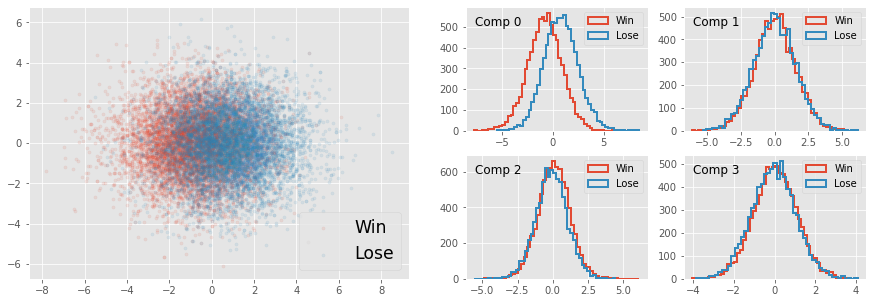

In [9]:
pca = utils.get_pca_model()

xf = pca.fit_transform(data[utils.ADVSTATFEATURES])
plt.figure(figsize=(15,5))
mask = data.result.astype(bool)
plt.subplot(1,2,1)
plt.scatter(xf[mask,0], xf[mask,1], s=10, alpha=0.1, label="Win")
plt.scatter(xf[~mask,0], xf[~mask,1], s=10, alpha=0.1, label="Lose")
plt.legend(fontsize='xx-large')
for i,subplot in zip([0,1,2,3],[3,4,7,8]):
    plt.subplot(2,4,subplot)
    plt.hist(xf[mask,i], bins=50, histtype='step', lw=2, label='Win')
    plt.hist(xf[~mask,i], bins=50, histtype='step', lw=2, label='Lose')
#     plt.title('Comp '+str(i))
    plt.text(0.05,0.85,'Comp '+str(i), transform=plt.gca().transAxes, fontsize='large')
    plt.legend()
pca.named_steps['pca'].components_[0,:]
pca.named_steps['pca'].explained_variance_ratio_

### Remove two years at a time for a validation set and perform 5-fold cross validation
We try a variety of models:
* "HA" : as a baseline, a logistic regression using **only** home/away feature
* "raweffdiff" : Logistic regression using only raw efficiencies (non-SoS-corrected) and home/away. Expected to perform poorly
* "effdiff" : use SoS-corrected efficiencies
* "advstats" : Use PCA features derived above
* "advstats_xgb" : Same as above but XGBClassifier instead of logistic regression

"advstats" logistic regression with PCA values performs best in 4 out of 5 folds, and is a close second in the 5th.

advstats  : 0.5735
effdiff   : 0.5725
advstats_xgb: 0.5704
raweffdiff: 0.5642


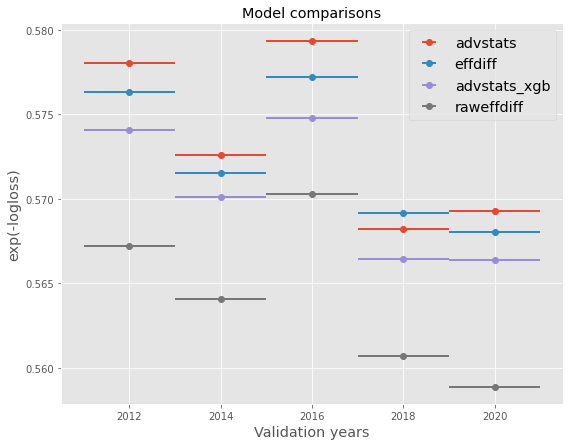

In [10]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
    
logreg = LogisticRegression(C=1.0)
xgbcls = XGBClassifier(max_depth=2, n_estimators=50)

PCAFEATURES = ["PCA"+str(i) for i in range(len(utils.ADVSTATFEATURES))]
models = {
#     "HA" : [],
    "raweffdiff" : ["raweffdiff"],    
    "effdiff" : ["effdiff"],
#     "bad" : ["Otovr"],
    "advstats" : PCAFEATURES,
    "advstats_xgb" : PCAFEATURES
}

model_scores = defaultdict(list)
model_coeffs = defaultdict(list)
years = data.season.unique()
NVALID = 2
start_years = years[:len(years)-NVALID+1:NVALID]
for start_valid in start_years:
    valid_years = list(range(start_valid, start_valid+NVALID))
    train_years = sorted(set(years)-set(valid_years))
    
    data_train, data_valid = utils.train_test_split_by_year(data, train_years, valid_years, pca_model=pca)
    
    for name,features in models.items():
        X_train = data_train[features+['HA']]
        y_train = data_train.result
        X_valid = data_valid[features+['HA']]
        y_valid = data_valid.result
        
        if "xgb" not in name:
            logreg.fit(X_train, y_train)
            probs = logreg.predict_proba(X_valid)
            score = log_loss(y_valid, probs)
            model_scores[name].append(np.exp(-score))
            model_coeffs[name].append(logreg.coef_[0,:])
        else:
            xgbcls.fit(X_train, y_train)
            probs = xgbcls.predict_proba(X_valid)
            score = log_loss(y_valid, probs)
            model_scores[name].append(np.exp(-score))

plt.figure(figsize=(9,7))
xs = start_years
for name,scores in sorted(model_scores.items(), key=lambda x:np.mean(x[1]), reverse=True):
    print(f'{name:10s}: {np.mean(scores):.4f}')
    plt.errorbar(xs+NVALID/2.0, scores, xerr=NVALID/2.0, fmt='o', lw=2, label=name)
plt.xlabel('Validation years', fontsize='x-large')
plt.ylabel('exp(-logloss)', fontsize='x-large')
plt.title('Model comparisons')
plt.legend(fontsize='x-large');

# model_coeffs['advstats']

### Just to make sure we didn't accidentally miss a good model, try a few XGBClassifiers over a grid of hyperparameters
Does not outperform logistic regression.

In [11]:
data_train, data_valid = utils.train_test_split_by_year(data, list(range(2011,2018)), [2018,2019,2020], pca_model=pca)

best = (0,0,0)
for i in [2,3,4]:
    for j in [10,20,50,100]:
        xgbcls = XGBClassifier(max_depth=i, n_estimators=j)
        xgbcls.fit(X_train, y_train)
        probs = xgbcls.predict_proba(X_valid)
        score = np.exp(-log_loss(y_valid, probs))
        if score > best[2]:
            best = (i,j,score)
print('(max_depth, n_estimatores, best_score)',best)

(max_depth, n_estimatores, best_score) (2, 50, 0.566399108055668)


### Generate predictions for every game using other years as training
So we can make some pretty plots.

In [20]:
probs = []
for year in data.season.unique():
    train_years = data.season.unique().tolist()
    train_years.remove(year)
    data_train, data_valid = utils.train_test_split_by_year(data, train_years, [year], pca_model=pca)
    X_train = data_train[PCAFEATURES+['HA']]
    y_train = data_train.result
    X_valid = data_valid[PCAFEATURES+['HA']]
    
    logreg.fit(X_train, y_train)
    probs += logreg.predict_proba(X_valid)[:,1].tolist()

data["predicted_prob"] = probs

def get_upset_prob(row):
    # somewhat arbitrarily define an upset as an unranked team 
    # beating a team ranked #20 or better, or a team beating
    # a team ranked at least 10 spots higher than itself
    if (row.rank1 < 0 and 0 < row.rank2 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank1-row.rank2 > 10):
        return row.predicted_prob
    if (row.rank2 < 0 and 0 < row.rank1 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank2-row.rank1 > 10):
        return 1-row.predicted_prob
    return -1.0  

def is_upset(row):
    if (row.rank1 < 0 and 0 < row.rank2 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank1-row.rank2 > 10):
        return row.result
    if (row.rank2 < 0 and 0 < row.rank1 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank2-row.rank1 > 10):
        return 1-row.result
    return 0

data['upset_prob'] = data.apply(get_upset_prob, axis=1)
data['is_upset'] = data.apply(is_upset, axis=1)

data[['result','predicted_prob','rank1','rank2','upset_prob','is_upset']].head(5)

,result,predicted_prob,rank1,rank2,upset_prob,is_upset
0,1,0.696622,-1,-1,-1.000000,0
1,1,0.783395,-1,-1,-1.000000,0
2,0,0.284421,-1,14,0.284421,0
3,0,0.283433,-1,-1,-1.000000,0
4,1,0.619690,6,-1,0.380310,0
5,1,0.730305,-1,-1,-1.000000,0
6,1,0.856439,19,-1,0.143561,0
7,1,0.881619,-1,-1,-1.000000,0
8,1,0.866584,9,-1,0.133416,0
9,0,0.229398,18,1,0.229398,0


### Check model calibration by plotting observed win % in bins of predicted probability
This falls on a straight line, showing that generated probabilities are meaningful

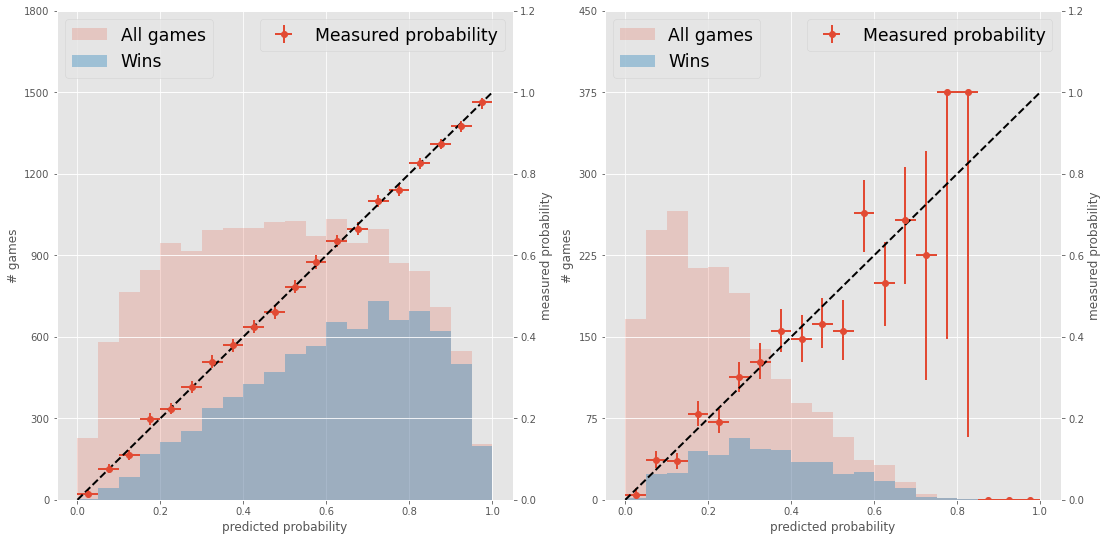

In [40]:
from statsmodels.stats.proportion import proportion_confint

binedges = np.linspace(0,1,21)

fig, axs = plt.subplots(1, 2, figsize=(18,9))
for iax, ax in enumerate(axs):
    ws = []
    errs = []
    for i in range(len(binedges)-1):
        if iax==0:
            num = ((data.predicted_prob > binedges[i]) & (data.predicted_prob < binedges[i+1]) & data.result).sum()
            den = ((data.predicted_prob > binedges[i]) & (data.predicted_prob < binedges[i+1])).sum()
        else:
            num = ((data.upset_prob > binedges[i]) & (data.upset_prob < binedges[i+1]) & data.is_upset).sum()
            den = ((data.upset_prob > binedges[i]) & (data.upset_prob < binedges[i+1])).sum()
        f = num/den if den>0 else 0
        ws.append(f)
        low, high = proportion_confint(int(num), int(den), alpha=0.31, method='beta') if den>0 else (0,0)
        errs.append([f-low, high-f])

    if iax==0:
        dens = data.predicted_prob
        nums = data.predicted_prob[data.result.astype(bool)]
    else:
        dens = data.upset_prob
        nums = data.upset_prob[data.is_upset.astype(bool)]
        
    ax.hist(dens, bins=binedges, histtype='stepfilled', lw=2, alpha=0.2, label='All games')
    ax.hist(nums, bins=binedges, histtype='stepfilled', lw=2, alpha=0.4, label='Wins')
    ax.set_xlabel('predicted probability')
    ax.set_ylabel('# games')
    ymax = 1800 if iax==0 else 450
    ax.set_ylim(0,ymax)
    ax.set_yticks(range(0,ymax+1, int(ymax/6)))
    ax.legend(loc='upper left', fontsize='xx-large')
    ax2 = ax.twinx()
    ax2.plot([0,1],[0,1],'k--',lw=2)
    ax2.errorbar(0.5*(binedges[:-1]+binedges[1:]), ws, yerr=np.array(errs).T, xerr=0.5*(binedges[1]-binedges[0]), 
                 fmt = 'o', lw=2, label='Measured probability')
    ax2.set_xlabel('predicted probability')
    ax2.set_ylabel('measured probability')
    ax2.set_ylim(0,1.2)
    ax2.legend(fontsize='xx-large')


### Perform some linear regressions to predict pace, total score, score margin

Regression for pace
[0.01468278] -1.7171342111216603
0.30399036029152326
3.812820512871875
Regression for total score
[0.00475359] 9.760462898804576
0.22433613608644265
13.77984639291409
Regression for score margin
[0.01086432 4.32542854] 0.07611843150275885
0.3108313085242639
8.70667780209571


Text(0, 0.5, 'Predicted win probability')

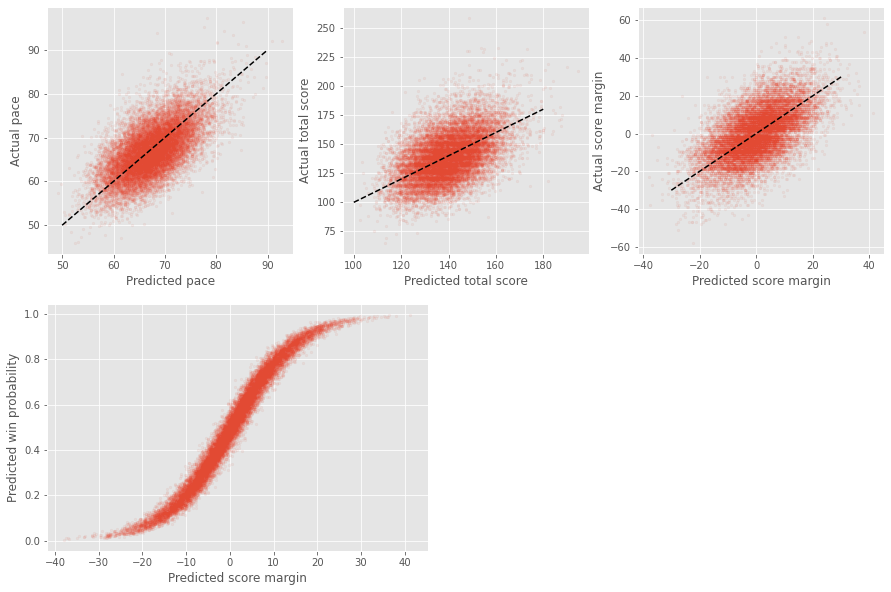

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm


linreg = LinearRegression(fit_intercept=True)

p1 = data.pace1.values
p2 = data.pace2.values
ed = data.effdiff.values
es = data.effsum.values
act_pace = data.poss.values
act_totscore = data.totscore.values
act_margin = data.margin.values

def get_weights(vals):
    # weight pace regression
    mu = vals.mean()
    std = vals.std()
    return 1/np.maximum(0.01,norm.pdf(vals, loc=mu, scale=std))

print("Regression for pace")
X = np.array([p1*p2]).T
linreg.fit(X, act_pace, get_weights(act_pace))
pred_pace = linreg.predict(X)
data["predicted_pace"] = pred_pace
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_pace))
print(mean_absolute_error(act_pace,pred_pace))

print("Regression for total score")
X = np.array([pred_pace*es]).T
linreg.fit(X, act_totscore, get_weights(act_totscore))
pred_score = linreg.predict(X)
data["predicted_totscore"] = pred_score
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_totscore))
print(mean_absolute_error(act_totscore,pred_score))

print("Regression for score margin")
X = np.array([pred_pace*ed, data.HA]).T
linreg.fit(X, act_margin, get_weights(act_margin))
pred_margin = linreg.predict(X)
data["predicted_margin"] = pred_margin
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_margin))
print(mean_absolute_error(act_margin,pred_margin))

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.scatter(data.predicted_pace, data.poss, s=7, alpha=0.07)
plt.plot([50,90],[50,90],'k--')
plt.xlabel('Predicted pace')
plt.ylabel('Actual pace')
plt.subplot(2,3,2)
plt.scatter(data.predicted_totscore, data.totscore, s=7, alpha=0.07)
plt.plot([100,180],[100,180],'k--')
plt.xlabel('Predicted total score')
plt.ylabel('Actual total score')
plt.subplot(2,3,3)
plt.scatter(data.predicted_margin, data.margin, s=7, alpha=0.07)
plt.plot([-30,30],[-30,30],'k--')
plt.xlabel('Predicted score margin')
plt.ylabel('Actual score margin')
plt.subplot(2,2,3)
plt.scatter(data.predicted_margin, data.predicted_prob, s=7, alpha=0.07)
plt.xlabel("Predicted score margin")
plt.ylabel("Predicted win probability")